# Machine Learning for Insurance Example

### Adopted from [Randal S. Olson](http://www.randalolson.com/) 
### Edited by ASKS Data Science Group
#### Supported by [THRES]

## Table of contents

1. [License](#License)

2. [Step 1: Problem Setting](#Step-1:-Understanding-the-)

3. [Step 2: Checking the data](#Step-2:-Checking-the-data)

4. [Step 3: Preparing the data](#Step-3:-Preparing-the-data)

5. [Step 4: Classification](#Step-4:-Classification)
    - [Decision Tree](#Decision-Tree)
    - [Random Forest](#Random-Forest)
    - [kNN](#kNN)
    - [SVM](#SVM)
    - [Naive Bayes](#Decision-Tree)
    - [Binary Classification](#Binary-Classification)
6. [Step 5: Regression](#Step-5:-Regression)
    - [Regression Tree](#Regression-Tree)
    - [Random Forest Regressor](#Random-Forest-Regressor)
    - [Linear Regression](#Linear-Regression)
    - [Neural Network](#Neural-Network)
7. [Step 6: Methodologies](#Step-6:-Methodologies)
    - [Feature Selection](#Feature-Selection)
    - [Parameter Tuning](#Parameter-Tuning)
    - [Models Comparison](#Models-Comparison)   

## License

Please see the original [repository README file](https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects#license) for the licenses and usage terms for the instructional material and code in this notebook. I cloned and then edited it from the original authors. For any further usage, please follows them.

## Step 1: The question

For this workshop, we will work on our example from yesterday. We will try to classify the medical-risk-level (i.e., class) of the customered based on provided data. We are still building a data analysis pipeline for a smartphone app that will be able to classify the medical-risk of customer. However, we will explore multiple models. Since we learn that it's possible to predict the model with high accuracy as the classification task. We will look at the problem as both the regression task, where we want to predict the actual medical charges.

## Step 2: Checking the data

If we work with the new data, we should begin the process we did yesterday. Now, let's begin from a new. While encoding categorical feature is not necessary in principle, it is usually a requirement for all classification algorithms in sklearn. So, we will convert them just as yesterday as well

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

insurance_data = pd.read_csv('../data/insurance.csv', na_values=['NA'])
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,middle,16884.92400
1,18,male,33.770,1,no,south,1725.55230
2,28,male,33.000,3,no,south,4449.46200
3,33,male,22.705,0,no,north,21984.47061
4,32,male,28.880,0,no,north,3866.85520


Next, we look at the distribution of our data by printing out some summary statistics about the data set.


In [2]:
insurance_data.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,south,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


## Step 3: Preparing the data

Now that we've looked at the data set, we need to prepare them before we proceed with the analysis for both the regression, and the classification. Again, we will use the DataFrame for both tasks. From the previous day, we drop all customers with charges > 60,000. 

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder

#We usually need to encode the categorical data for the classifiers
lb_make = LabelEncoder()
insurance_data["sex_code"] = lb_make.fit_transform(insurance_data["sex"])
insurance_data["smoker_code"] = lb_make.fit_transform(insurance_data["smoker"])
insurance_data["region_code"] = lb_make.fit_transform(insurance_data["region"])
insurance_data = insurance_data.loc[insurance_data['charges'] <= 60000];
insurance_data.loc[insurance_data['charges']> 60000]

,age,sex,bmi,children,smoker,region,charges,sex_code,smoker_code,region_code


Now, let us prepare the multi-class classification with three class types.

In [4]:
insurance_data["risk_level"] = pd.cut(insurance_data["charges"],bins=[0,15000,30000,60000],right=True,labels=["LOW", "MID", "HIGH"])
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges,sex_code,smoker_code,region_code,risk_level
0,19,female,27.900,0,yes,middle,16884.92400,0,1,0,MID
1,18,male,33.770,1,no,south,1725.55230,1,0,3,LOW
2,28,male,33.000,3,no,south,4449.46200,1,0,3,LOW
3,33,male,22.705,0,no,north,21984.47061,1,0,1,MID
4,32,male,28.880,0,no,north,3866.85520,1,0,1,LOW


Next, let's drop the charges column out for classifcation.

In [5]:
insurance_classification = insurance_data.drop(columns=['sex', 'smoker', 'region','charges'])
insurance_classification.head()

,age,bmi,children,sex_code,smoker_code,region_code,risk_level
0,19,27.900,0,0,1,0,MID
1,18,33.770,1,1,0,3,LOW
2,28,33.000,3,1,0,3,LOW
3,33,22.705,0,1,0,1,MID
4,32,28.880,0,1,0,1,LOW


Now, let's drop the risk_level for regression.

In [6]:
insurance_regression = insurance_data.drop(columns=['sex', 'smoker', 'region','risk_level'])
insurance_regression.head()

## Step 4: Classification

After data preparation process, our data is assume to be cleaned. Next, we can create a classification model.

Remember: **Bad data leads to bad models.** Always check your data first.

<hr />

Supervised Learning Methodologies

Let's set up our data first, were we will not touch our test data.

In [7]:
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# We can extract the data in this format from pandas like this:
all_inputs = insurance_classification[['age', 'bmi', 'children', 'sex_code', 'smoker_code', 'region_code']]
# Similarly, we can extract the class labels
all_labels = insurance_classification['risk_level']

# Let us have a 30% holdout data for testing
(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.3)

In [8]:
#This function is taken from sklearn document
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Decision Tree

With our data split, we can fit models to our data, starting with our good old decision tree classifer.

In [9]:
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
print('Decision Tree model acuracy is ',accuracy)


Decision Tree model acuracy is  0.8528678304239401


Decision Tree model evaluations are: 
              precision    recall  f1-score   support

        HIGH       0.90      0.88      0.89        43
         LOW       0.89      0.93      0.91       290
         MID       0.61      0.51      0.56        68

   micro avg       0.85      0.85      0.85       401
   macro avg       0.80      0.78      0.79       401
weighted avg       0.85      0.85      0.85       401

Confusion matrix, without normalization
[[269  18   3]
 [ 32  35   1]
 [  1   4  38]]


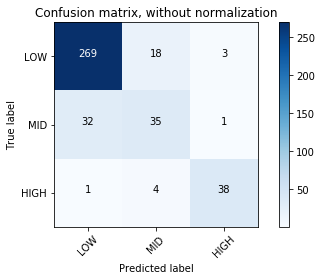

In [10]:
# Compute the evaluation matrix
print('Decision Tree model evaluations are: ')
testing_pred = decision_tree_classifier.predict(testing_inputs)
print(classification_report(testing_classes, testing_pred))
cnf_matrix = confusion_matrix(testing_classes, testing_pred, labels=["LOW", "MID", "HIGH"]);
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["LOW", "MID", "HIGH"],
                      title='Confusion matrix, without normalization')

### Random Forest

In practice, Random Forest classifier usually works better than individual decision tree. It often outperforms many other complex model such as Neural Network and SVM. Those models suffer from variance in the data. **Random Forest classifiers** work around such limitations by creating a whole bunch of decision trees (hence "forest") — each trained on random subsets of training samples (drawn with replacement) and features (drawn without replacement) — and have the decision trees work together to make a more accurate classification.

Let that be a lesson for us: **Even in Machine Learning, we get better results when we work together!**

Let's see if a Random Forest classifier works better here.

The great part about scikit-learn is that the training, testing, parameter tuning, etc. process is the same for all models, so we only need to plug in the new classifier.

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest classifier
random_forest_classifier = RandomForestClassifier()

# Train the classifier on the training set
random_forest_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
accuracy = random_forest_classifier.score(testing_inputs, testing_classes)
print('Random Forest model acuracy is ',accuracy)

Random Forest model acuracy is  0.8927680798004988


Random Forest model evaluations are: 
              precision    recall  f1-score   support

        HIGH       0.90      0.88      0.89        43
         LOW       0.89      1.00      0.94       290
         MID       0.89      0.46      0.60        68

   micro avg       0.89      0.89      0.89       401
   macro avg       0.89      0.78      0.81       401
weighted avg       0.89      0.89      0.88       401

Confusion matrix, without normalization
[[289   1   0]
 [ 33  31   4]
 [  2   3  38]]


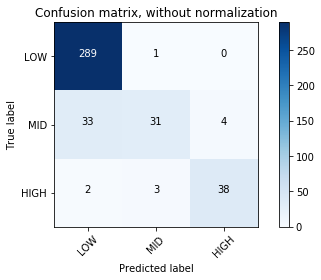

In [12]:
# Compute the evaluation matrix
print('Random Forest model evaluations are: ')
testing_pred = random_forest_classifier.predict(testing_inputs)
print(classification_report(testing_classes, testing_pred))
cnf_matrix = confusion_matrix(testing_classes, testing_pred, labels=["LOW", "MID", "HIGH"]);
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["LOW", "MID", "HIGH"],
                      title='Confusion matrix, without normalization')

### kNN

One of the simplest model, and similar to how many of us learn, is k Nearest Neighbors. It simply makes a prediction of the future example based on the majority of the neighbors. For example, for a new customer, if k = 5, and 3 out of 5 nearest neighbors of the new customer is labeled as HIGH, then the new customer is considered as HIGH. The only catch is that we need to set the parameter k, and how to determine the nearest neighbors. kNN is not one of the top performers. However, it is simple enough to keep it in the comparison pool. And in some cases, it is quite good.

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Create kNN classifier
kNN_classifier = KNeighborsClassifier()

# Train the classifier on the training set
kNN_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
accuracy = kNN_classifier.score(testing_inputs, testing_classes)
print('kNN model acuracy is ',accuracy)

kNN model acuracy is  0.7082294264339152


kNN model evaluations are: 
              precision    recall  f1-score   support

        HIGH       0.25      0.12      0.16        43
         LOW       0.74      0.95      0.83       290
         MID       0.40      0.06      0.10        68

   micro avg       0.71      0.71      0.71       401
   macro avg       0.46      0.37      0.36       401
weighted avg       0.63      0.71      0.64       401

Confusion matrix, without normalization
[[275   5  10]
 [ 59   4   5]
 [ 37   1   5]]


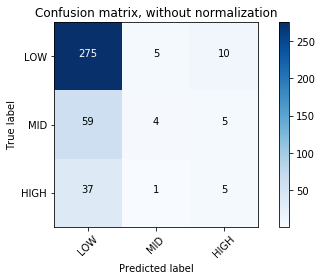

In [14]:
# Compute the evaluation matrix
print('kNN model evaluations are: ')
testing_pred = kNN_classifier.predict(testing_inputs)
print(classification_report(testing_classes, testing_pred))
cnf_matrix = confusion_matrix(testing_classes, testing_pred, labels=["LOW", "MID", "HIGH"]);
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["LOW", "MID", "HIGH"],
                      title='Confusion matrix, without normalization')

### SVM

SVM, or Support Vector Machine, is one of the supervised learning methods. It is good at finding the boundary to separate multiple classes in high dimensional space. However, in its basic form, it can only handle the class with two values (binary classification). To make it a multi-class classification (like our problem), we can also deploy its implementation in one of the sklearn library. We will first solve our multiclass classification problem, and then show how SVM can solve binary classification problem in the next section. Let's see how well it performs.

In [15]:
from sklearn import svm

# Create SVM classifier 
lin_svm_classifier = svm.LinearSVC()

# Train the classifier on the training set
lin_svm_classifier.fit(training_inputs, training_classes) 

# Validate the classifier on the testing set using classification accuracy
accuracy = lin_svm_classifier.score(testing_inputs, testing_classes)
print('SVM model acuracy without converging is ',accuracy)

SVM model acuracy without converging is  0.8453865336658354


In [16]:
# Notice that the default numbers of iteration is 1000 and it did not converge. Let's try to increase it.
lin_svm_classifier = svm.LinearSVC(max_iter=200000)
lin_svm_classifier.fit(training_inputs, training_classes) 
accuracy = lin_svm_classifier.score(testing_inputs, testing_classes)
print('SVM model acuracy is ',accuracy)

SVM model acuracy is  0.8678304239401496


SVM model evaluations are: 
              precision    recall  f1-score   support

        HIGH       0.78      0.91      0.84        43
         LOW       0.88      0.99      0.94       290
         MID       0.84      0.31      0.45        68

   micro avg       0.87      0.87      0.87       401
   macro avg       0.83      0.74      0.74       401
weighted avg       0.86      0.87      0.84       401

Confusion matrix, without normalization
[[288   2   0]
 [ 36  21  11]
 [  2   2  39]]


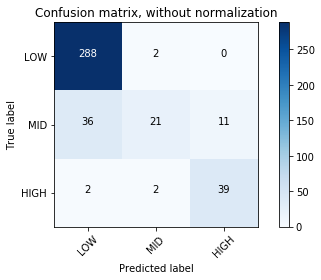

In [17]:
# Now that it converges. Let's continue the evaluation
print('SVM model evaluations are: ')
testing_pred = lin_svm_classifier.predict(testing_inputs)
print(classification_report(testing_classes, testing_pred))
cnf_matrix = confusion_matrix(testing_classes, testing_pred, labels=["LOW", "MID", "HIGH"]);
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["LOW", "MID", "HIGH"],
                      title='Confusion matrix, without normalization')

### Naive Bayes

Naive Bayes is a probabilistic based model. It uses probability theory to create the model based on the training data. It does not always perform well in general. However, like kNN, it can be very good in certain cases. Note that we are able to use GaussianNB, because we encoded the categorical data. 

In [18]:
from sklearn.naive_bayes import GaussianNB

# Create SVM classifier 
nb_classifier = GaussianNB()

# Train the classifier on the training set
nb_classifier.fit(training_inputs, training_classes) 

# Validate the classifier on the testing set using classification accuracy
accuracy = nb_classifier.score(testing_inputs, testing_classes)
print('NB model acuracy without converging is ',accuracy)

NB model acuracy without converging is  0.8753117206982544


NB model evaluations are: 
              precision    recall  f1-score   support

        HIGH       0.83      0.91      0.87        43
         LOW       0.88      0.99      0.94       290
         MID       0.86      0.35      0.50        68

   micro avg       0.88      0.88      0.88       401
   macro avg       0.86      0.75      0.77       401
weighted avg       0.87      0.88      0.85       401

Confusion matrix, without normalization
[[288   2   0]
 [ 36  24   8]
 [  2   2  39]]


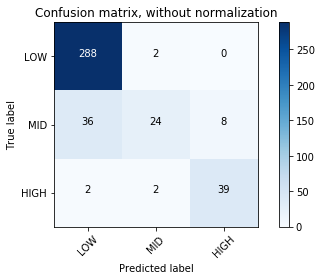

In [19]:
# Now that it converges. Let's continue the evaluation
print('NB model evaluations are: ')
testing_pred = nb_classifier.predict(testing_inputs)
print(classification_report(testing_classes, testing_pred))
cnf_matrix = confusion_matrix(testing_classes, testing_pred, labels=["LOW", "MID", "HIGH"]);
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["LOW", "MID", "HIGH"],
                      title='Confusion matrix, without normalization')

### Binary classification

In most problem, we only need to identify a type A or B answer. We will demonstrate the binary classification task by reducing the data into two classes, LOW and HIGH. Note that, MID will be merged with LOW. And prepare the training/testing datasets.

In [20]:
insurance_binary = insurance_classification
insurance_binary.loc[insurance_binary["risk_level"] == "MID", "risk_level"] = "LOW"

# check that we have only two class
assert len(insurance_binary['risk_level'].unique()) == 2

all_bin_inputs = insurance_binary[['age', 'bmi', 'children', 'sex_code', 'smoker_code', 'region_code']]
# Similarly, we can extract the class labels
all_bin_labels = insurance_binary['risk_level']

# Let us have a 30% holdout data for testing
(training_bin_inputs, testing_bin_inputs, training_bin_classes, testing_bin_classes) = train_test_split(all_bin_inputs, all_bin_labels, test_size=0.3)


Let us see how the classifiers above perform in this setting. 

In [21]:
#Decision Tree
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(training_bin_inputs, training_bin_classes)
accuracy = decision_tree_classifier.score(testing_bin_inputs, testing_bin_classes)
# Validate the classifier on the testing set using classification accuracy
print('Decision Tree evaluation scores are: ')
print('Accuracy: ',accuracy)
testing_bin_pred = decision_tree_classifier.predict(testing_bin_inputs)
print(classification_report(testing_bin_classes, testing_bin_pred))

Decision Tree evaluation scores are: 
Accuracy:  0.9775561097256857
              precision    recall  f1-score   support

        HIGH       0.90      0.92      0.91        49
         LOW       0.99      0.99      0.99       352

   micro avg       0.98      0.98      0.98       401
   macro avg       0.94      0.95      0.95       401
weighted avg       0.98      0.98      0.98       401



In [22]:
#Random Forest
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(training_bin_inputs, training_bin_classes)
accuracy = random_forest_classifier.score(testing_bin_inputs, testing_bin_classes)
# Validate the classifier on the testing set using classification accuracy
print('Random Forest evaluation scores are: ')
print('Accuracy: ',accuracy)
testing_bin_pred = random_forest_classifier.predict(testing_bin_inputs)
print(classification_report(testing_bin_classes, testing_bin_pred))

Random Forest evaluation scores are: 
Accuracy:  0.9850374064837906
              precision    recall  f1-score   support

        HIGH       1.00      0.88      0.93        49
         LOW       0.98      1.00      0.99       352

   micro avg       0.99      0.99      0.99       401
   macro avg       0.99      0.94      0.96       401
weighted avg       0.99      0.99      0.98       401



In [23]:
#kNN
kNN_classifier = KNeighborsClassifier()
kNN_classifier.fit(training_bin_inputs, training_bin_classes)
accuracy = kNN_classifier.score(testing_bin_inputs, testing_bin_classes)
print('kNN evaluation scores are: ')
print('Accuracy ',accuracy)
testing_bin_pred = kNN_classifier.predict(testing_bin_inputs)
print(classification_report(testing_bin_classes, testing_bin_pred))

kNN evaluation scores are: 
Accuracy  0.8802992518703242
              precision    recall  f1-score   support

        HIGH       0.60      0.06      0.11        49
         LOW       0.88      0.99      0.94       352

   micro avg       0.88      0.88      0.88       401
   macro avg       0.74      0.53      0.52       401
weighted avg       0.85      0.88      0.84       401



In [24]:
#SVM 
lin_svm_classifier = svm.LinearSVC(max_iter=200000)
lin_svm_classifier.fit(training_bin_inputs, training_bin_classes)
accuracy = lin_svm_classifier.score(testing_bin_inputs, testing_bin_classes)
print('SVM evaluation scores are: ')
print('Accuracy ',accuracy)
testing_bin_pred = lin_svm_classifier.predict(testing_bin_inputs)
print(classification_report(testing_bin_classes, testing_bin_pred))

SVM evaluation scores are: 
Accuracy  0.9750623441396509
              precision    recall  f1-score   support

        HIGH       0.91      0.88      0.90        49
         LOW       0.98      0.99      0.99       352

   micro avg       0.98      0.98      0.98       401
   macro avg       0.95      0.93      0.94       401
weighted avg       0.97      0.98      0.97       401



In [25]:
#Naive Bayes
nb_classifier = GaussianNB()
nb_classifier.fit(training_bin_inputs, training_bin_classes) 
accuracy = nb_classifier.score(testing_bin_inputs, testing_bin_classes)
print('NB evaluation scores are: ')
print('Accuracy ',accuracy)
testing_bin_pred = nb_classifier.predict(testing_bin_inputs)
print(classification_report(testing_bin_classes, testing_bin_pred))

NB evaluation scores are: 
Accuracy  0.9052369077306733
              precision    recall  f1-score   support

        HIGH       0.57      0.94      0.71        49
         LOW       0.99      0.90      0.94       352

   micro avg       0.91      0.91      0.91       401
   macro avg       0.78      0.92      0.83       401
weighted avg       0.94      0.91      0.91       401



## Step 5: Regression

In Machine Learning, Regression Analysis is used to predict a certain value of the target features. For our case, we are trying to predict the charges of a given customer. Also, we need a new way to evaluate the regression models. Two of the common metrics are mean squared error, and the coefficient of determination (R^2 score)

In [26]:
from sklearn.metrics import mean_squared_error, r2_score

# We can extract the data in this format from pandas like this:
all_inputs = insurance_regression[['age', 'bmi', 'children', 'sex_code', 'smoker_code', 'region_code']]
# Similarly, we can extract the class labels
all_outputs = insurance_regression['charges']

# Let us have a 30% holdout data for testing
(training_inputs, testing_inputs, training_outputs, testing_outputs) = train_test_split(all_inputs, all_outputs, test_size=0.3)

Now we will try a few regression models in SK-learn

### Regression Tree

In [27]:
from sklearn.tree import DecisionTreeRegressor

regression_tree = DecisionTreeRegressor()
# Train the classifier on the training set
regression_tree.fit(training_inputs, training_outputs)

testing_pred = regression_tree.predict(testing_inputs)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(testing_outputs, testing_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(testing_outputs, testing_pred))

Mean squared error: 43303458.74
Variance score: 0.69


### Random Forest Regressor

In [28]:
from sklearn.ensemble import RandomForestRegressor

regression_forest = RandomForestRegressor()
regression_forest.fit(training_inputs, training_outputs)

testing_pred = regression_forest.predict(testing_inputs)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(testing_outputs, testing_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(testing_outputs, testing_pred))

Mean squared error: 26440941.87
Variance score: 0.81


### Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(training_inputs, training_outputs)

testing_pred = linear_regression.predict(testing_inputs)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(testing_outputs, testing_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(testing_outputs, testing_pred))

Mean squared error: 34501522.18
Variance score: 0.76


### Neural Network

Neural network is a once-again famous classifier because of the rise of deep learning. It is another classifier/regressor that you can try on your problem. 

In [30]:
from sklearn.neural_network import MLPRegressor
nn_regression = MLPRegressor(max_iter=20000)
nn_regression.fit(training_inputs, training_outputs)

testing_pred = nn_regression.predict(testing_inputs)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(testing_outputs, testing_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(testing_outputs, testing_pred))

Mean squared error: 35169948.78
Variance score: 0.75


## Step 6: Methodologies

Things that can help you improve your model's performance are the feature selection process, and the parameter tuning. And then, you need to be able to compare them to find the best model to report to your boss. We will illustrate these processes in the classification task. 

In [31]:
all_inputs = insurance_classification[['age', 'bmi', 'children', 'sex_code', 'smoker_code', 'region_code']]
all_labels = insurance_classification['risk_level']
# Let us have a 30% holdout data for testing for this part as well
(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.3)

### Feature Selection

Feature selection is simply selecting the 'relevant' feature to the current task. For this session we will limit our examples to one classifier only. It can be extended to other classifier. There are three common ways to do feature selection: (i) removing feature with low variance, (ii) univariate feature selection, and (iii) feature selection based on model's 'performance'.

For low variance feature selection, it is a baseline approach. It simply removes all features whose variance is lower than a given threshold. By default, sklearn removes all zero-variance features, i.e. features that have only one value. Most of the time, the value selected by expert will pass these test.

For univariate feature selection, it selects the best features based on the univariate statistical tests. Then we can choose the feature which pass certain test in sk-learn, such as SelectKBest, and SelectPercentile.

For the final method, we simply select the subset of features that will give the model's best performance. To find out the performance of each subset of features, we create a model using that given subset and test its performance.

In [32]:
# For low variance feature selection, we will set an example threshold to 80%
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
print(training_inputs.shape)
name = []
for i in training_inputs.columns:
    name.append(i)
training_vt = sel.fit_transform(training_inputs)
print(training_vt.shape)

(934, 6)
(934, 6)


In [33]:
# For Univariate feature selection we will use the chi square score with SelectKBest where k=2 as an example 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
print(training_inputs.shape)
selector = SelectKBest(chi2, k=2)
selector.fit(training_inputs,training_classes)
selected_index = selector.get_support(True)
print("after transform:",) 
training_new_inputs = selector.transform(training_inputs)
print(training_new_inputs.shape)
name = []
for i in training_inputs.columns:
    name.append(i)
training_new_df = pd.DataFrame(data=training_new_inputs,columns=[name[selected_index[0]], name[selected_index[1]]])
training_new_df.head()

(934, 6)
after transform:
(934, 2)


,bmi,smoker_code
0,30.115,0.0
1,29.700,0.0
2,27.940,1.0
3,22.880,1.0
4,31.680,1.0


In [34]:
#now we create a classifier with the newly transform data
lin_svm_classifier = svm.LinearSVC(max_iter=200000)
lin_svm_classifier.fit(training_new_df, training_classes) 
#then we must drop the testing data to have only the two columns
testing_new_df = testing_inputs[[testing_inputs.columns[selected_index[0]],testing_inputs.columns[selected_index[1]]]]
accuracy = lin_svm_classifier.score(testing_new_df, testing_classes)
print('SVM model acuracy is ',accuracy)

SVM model acuracy is  0.9850374064837906


In [35]:
#Next we select the feature by recursively eliminate the feature out of the original set
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

#Build a classification task using 2 informative features
rfc = RandomForestClassifier()
rfecv = RFECV(estimator=rfc, step=1, cv=5,scoring='accuracy') 
rfecv.fit(training_inputs, training_classes)
training_rfecv_inputs = rfecv.transform(training_inputs)
training_rfecv_df = pd.DataFrame(data=training_rfecv_inputs,columns=training_inputs.columns[rfecv.support_])
training_rfecv_df.head()

,age,bmi,children,sex_code,smoker_code,region_code
0,64.0,30.115,3.0,0.0,0.0,1.0
1,55.0,29.700,2.0,0.0,0.0,0.0
2,29.0,27.940,1.0,0.0,1.0,3.0
3,53.0,22.880,1.0,0.0,1.0,3.0
4,18.0,31.680,2.0,1.0,1.0,3.0


Next we try out if the newly reduced dataset improve our performance

In [36]:
rfc = RandomForestClassifier()
rfc.fit(training_rfecv_df, training_classes)
test_rfecv_df = pd.DataFrame(data=testing_inputs,columns=training_inputs.columns[rfecv.support_])
accuracy = rfc.score(test_rfecv_df, testing_classes)
print('Random Forest model with Feature Selection acuracy is ',accuracy)

Random Forest model with Feature Selection acuracy is  0.970074812967581


### Parameter Tuning

As shown from yesterday, we can use grid search for parameter tuning.

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(training_inputs, training_classes)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier.fit(training_inputs, training_classes)

#testing using our holdout data
accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
print('Decision Tree with best parameters has the accuracy: {}'.format(accuracy))

Best score: 0.987152034261242
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 4, 'splitter': 'best'}
Decision Tree with best parameters has the accuracy: 0.940149625935162


### Models Comparison

To compare multiple models, we must use the same set of data to train and to test the models. Note that, previously we use the train/tune/test datasets in the supervised learning task. To avoid seeing the testing data, we select the best features and parameters using the train/tune datasets. In general, the accuracy of the test set can tell you a fair estimate of how well the classifiers are doing against one another. But, it still falls within the random chance of which data falls into the test dataset. For a rigurous comparison, the traditional  methodology is to use KFold cross validation. ***This is not the cross validation, cv() function, you have seen before*** For KFold, the data points in each fold are fixed. As such, we can compare the models using the same dataset.

KNN: 0.880171 (0.022302)
CART: 0.972321 (0.012013)
NB: 0.920581 (0.022095)


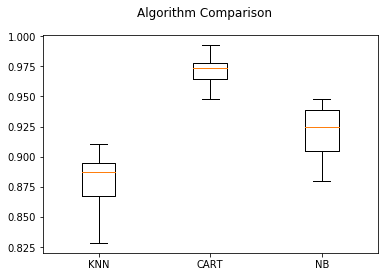

In [38]:
from sklearn import model_selection

models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
results = []
names = []
scoring = 'accuracy'
kfold = model_selection.KFold(n_splits=10, random_state=7)

for name, model in models:
    cv_results = model_selection.cross_val_score(model, all_inputs, all_labels, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [1]:
%load_ext watermark
%watermark -nmv --packages numpy,pandas,sklearn,matplotlib,seaborn,itertools

Thu Nov 22 2018 

CPython 3.7.1
IPython 7.1.1

numpy 1.15.4
pandas 0.23.4
sklearn 0.20.0
matplotlib 3.0.2
seaborn 0.9.0
itertools unknown

compiler   : Clang 6.0 (clang-600.0.57)
system     : Darwin
release    : 18.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
